In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp '/content/kaggle.json' ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download adhoppin/blood-cell-detection-datatset/

100% 11.8M/11.8M [00:00<00:00, 124MB/s]
100% 11.8M/11.8M [00:00<00:00, 123MB/s]


In [ ]:
! unzip /content/blood-cell-detection-datatset.zip -d '/content'

Archive:  /content/blood-cell-detection-datatset.zip
  inflating: /content/LICENSE        
  inflating: /content/README.dataset.txt  
  inflating: /content/README.md      
  inflating: /content/data.yaml      
  inflating: /content/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg  
  inflating: /content/test/images/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg  
  inflating: /content/test/images/BloodImage_00062_jpg.rf.1be1ca0ecdf783798fc10346baaa203e.jpg  
  inflating: /content/test/images/BloodImage_00090_jpg.rf.cdbf8f6ed3b93fa902a0bc991132cb40.jpg  
  inflating: /content/test/images/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg  
  inflating: /content/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg  
  inflating: /content/test/images/BloodImage_00113_jpg.rf.a17463f1ddc2e7729f935f8a74bc86a4.jpg  
  inflating: /content/test/images/BloodImage_00120_jpg.rf.6725d54bf5615683448eb1de4c7577ee.jpg  
  inflating: /

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

In [ ]:
import yaml
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter

In [ ]:
!cat ../content/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['Platelets', 'RBC', 'WBC']

In [ ]:
ls -1 ../content/train/images | wc -l

765


In [ ]:
# Load the YAML file
with open('../content/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with absolute path to kaggle data.
data_yaml['train'] = '/content/train/images'
data_yaml['val'] = '/content/valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [ ]:
data_dir = Path("../content/")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))

In [ ]:
resolutions = []

for image_path in image_paths:
    img = cv2.imread(str(image_path))
    h, w, _ = img.shape
    resolutions.append((w, h))

unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)

Unique resolutions: {(416, 416)}


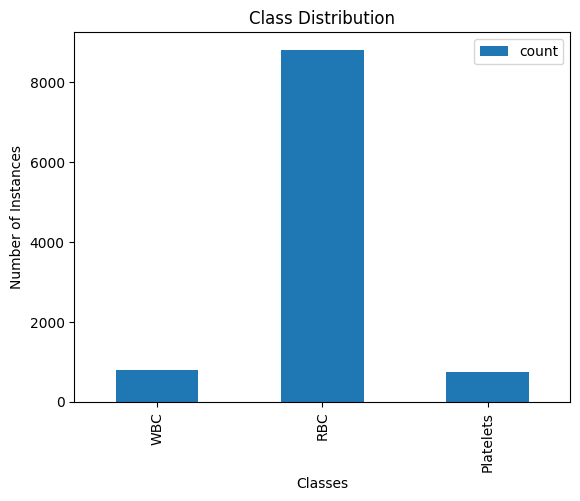

In [ ]:
class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

In [ ]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))

        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])

<Axes: >

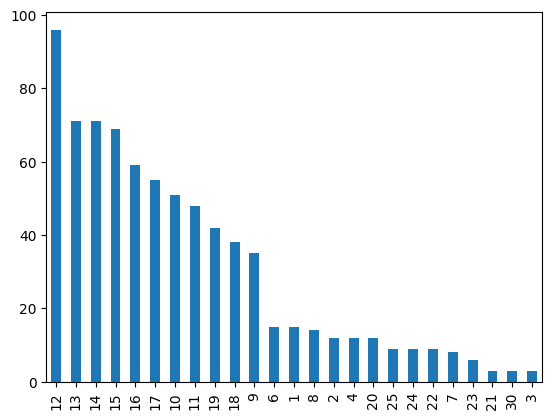

In [ ]:
# distribution of number of detections in an image
df['num_lines'].value_counts().plot(kind='bar')

<Axes: >

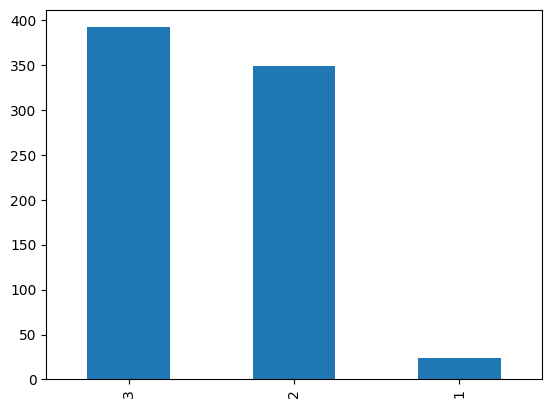

In [ ]:
# distribution of number of unique classes in images
df['unique_values'].value_counts().plot(kind='bar')

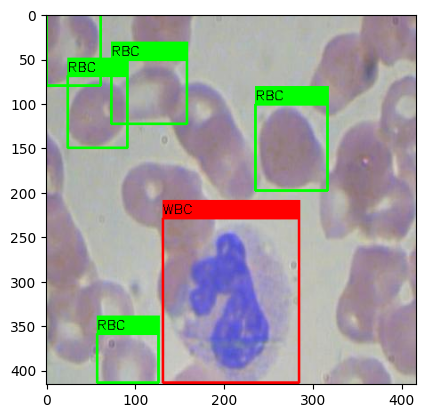

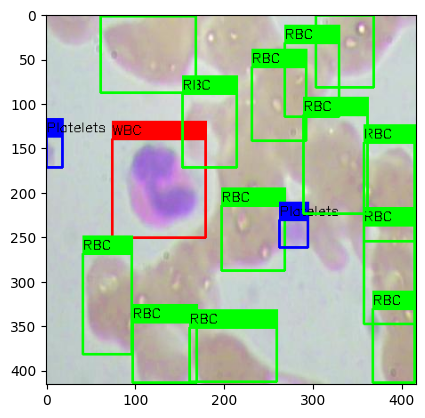

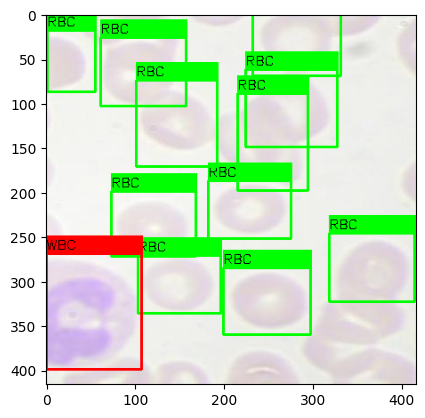

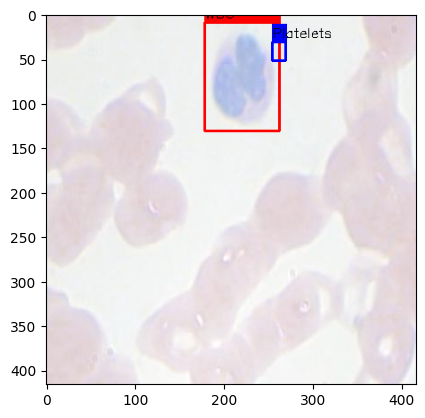

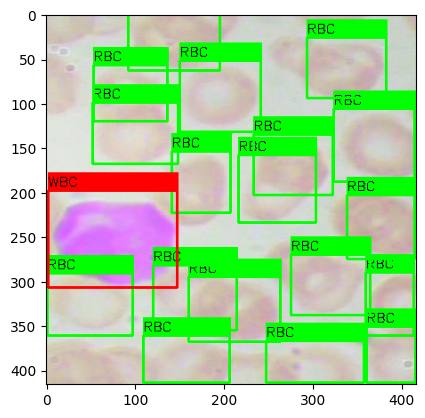

In [ ]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [ ]:
# baseline_model = YOLO('yolov8n.pt')

In [ ]:
# !yolo train model=yolov8n.pt data=data.yaml epochs=40 imgsz=640

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=40, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=

In [ ]:
import pandas as pd

csv_path = '/content/runs/detect/train/results.csv'
df = pd.read_csv(csv_path)
val_cls_loss = df.iloc[:, 8]
val_cls_loss

0     1.3870
1     1.1381
2     1.1395
3     1.2204
4     1.0781
5     1.1221
6     1.0544
7     1.0916
8     1.1215
9     1.3389
10    1.1095
11    1.0971
12    1.0392
13    1.1766
14    1.0612
15    1.0664
16    1.0252
17    1.0352
18    1.0312
19    1.0897
20    1.0606
21    1.0639
22    1.0637
23    1.0323
24    1.0231
25    1.0483
26    1.0409
27    1.0278
28    1.0268
29    1.0450
Name:            val/box_loss, dtype: float64

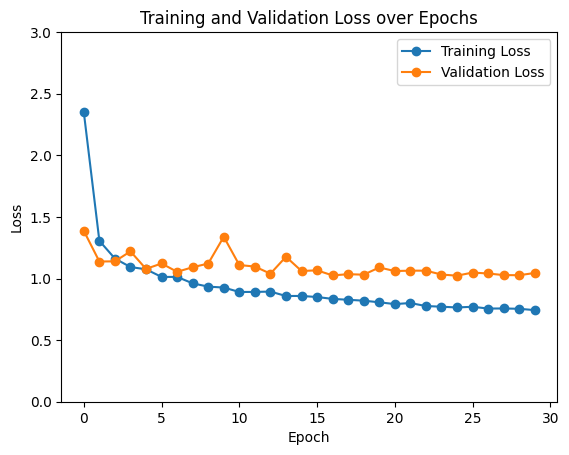

In [ ]:
import matplotlib.pyplot as plt

train_loss = [2.349, 1.306, 1.162, 1.093, 1.075, 1.013, 1.013, 0.9608, 0.9342, 0.9267,
              0.8909, 0.8912, 0.894, 0.8581, 0.8586, 0.8498, 0.8347, 0.8275, 0.8202, 0.8071,
              0.7925, 0.8011, 0.7767, 0.7713, 0.765, 0.7707, 0.7563, 0.7569, 0.7543, 0.7435]
val_loss = [1.3870, 1.1381, 1.1395, 1.2204, 1.0781, 1.1221, 1.0544, 1.0916, 1.1215, 1.3389,
            1.1095, 1.0971, 1.0392, 1.1766, 1.0612, 1.0664, 1.0252, 1.0352, 1.0312, 1.0897,
            1.0606, 1.0639, 1.0637, 1.0323, 1.0231, 1.0483, 1.0409, 1.0278, 1.0268, 1.0450]

plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()

In [ ]:
# load a pretrained model (recommended for training)
model = YOLO('yolov8n.pt')

# Use the model
results = model.train(data='data.yaml', epochs=30, batch=8)

100%|██████████| 6.23M/6.23M [00:00<00:00, 78.2MB/s]


Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=30, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False

100%|██████████| 755k/755k [00:00<00:00, 15.5MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:00<00:00, 2007.88it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 1486.24it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.29G      1.422       2.18      1.514         66        640: 100%|██████████| 96/96 [00:27<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

                   all         73        967      0.734      0.754      0.753      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.36G      1.261      1.249      1.384         96        640: 100%|██████████| 96/96 [00:19<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all         73        967      0.818      0.831      0.857      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.29G       1.23      1.157      1.335        109        640: 100%|██████████| 96/96 [00:21<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]

                   all         73        967      0.828      0.898      0.894      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.31G       1.22      1.099      1.319         54        640: 100%|██████████| 96/96 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

                   all         73        967      0.778      0.907      0.894      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.33G      1.216      1.075      1.303        113        640: 100%|██████████| 96/96 [00:21<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.31it/s]

                   all         73        967      0.818      0.891      0.888      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.28G      1.197       1.04        1.3         68        640: 100%|██████████| 96/96 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

                   all         73        967      0.788       0.88      0.878       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.26G      1.185      1.017      1.288        103        640: 100%|██████████| 96/96 [00:21<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]

                   all         73        967      0.785      0.905      0.882      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.31G      1.164     0.9676      1.266        125        640: 100%|██████████| 96/96 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]

                   all         73        967      0.854      0.894      0.912      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.29G      1.158     0.9636      1.265         74        640: 100%|██████████| 96/96 [00:21<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]

                   all         73        967      0.806      0.913      0.915      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.31G      1.138     0.9391      1.243        139        640: 100%|██████████| 96/96 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all         73        967      0.803      0.926      0.896      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.36G      1.145     0.9092      1.242         84        640: 100%|██████████| 96/96 [00:21<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]

                   all         73        967      0.823      0.894      0.905      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.32G      1.139     0.9114      1.239         90        640: 100%|██████████| 96/96 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]

                   all         73        967      0.841      0.921      0.923      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.31G      1.126     0.8967       1.23        112        640: 100%|██████████| 96/96 [00:21<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         73        967      0.862      0.909      0.929      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       1.3G      1.125     0.8833      1.226        115        640: 100%|██████████| 96/96 [00:20<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

                   all         73        967      0.788      0.872      0.885      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.29G      1.121     0.8696      1.221         80        640: 100%|██████████| 96/96 [00:20<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

                   all         73        967      0.817      0.898      0.909      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       1.3G      1.109     0.8611      1.218         97        640: 100%|██████████| 96/96 [00:19<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]

                   all         73        967      0.826      0.935       0.92      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.33G      1.099     0.8404      1.208        121        640: 100%|██████████| 96/96 [00:20<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


                   all         73        967      0.871      0.887      0.927      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.41G      1.101     0.8519       1.21         96        640: 100%|██████████| 96/96 [00:20<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]

                   all         73        967      0.823       0.89      0.891      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.31G      1.086      0.828      1.203        122        640: 100%|██████████| 96/96 [00:21<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

                   all         73        967      0.828      0.922      0.927       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.28G      1.073     0.8109      1.195         95        640: 100%|██████████| 96/96 [00:20<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]

                   all         73        967      0.856      0.897       0.93      0.641


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.39G      1.074     0.7917        1.2         61        640: 100%|██████████| 96/96 [00:21<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

                   all         73        967      0.834      0.898      0.917      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.25G      1.075     0.7836      1.203         66        640: 100%|██████████| 96/96 [00:18<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all         73        967      0.841      0.911      0.922      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.25G      1.068     0.7614      1.187         63        640: 100%|██████████| 96/96 [00:18<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all         73        967      0.811      0.942      0.925      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.25G      1.055     0.7505      1.182         73        640: 100%|██████████| 96/96 [00:19<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

                   all         73        967      0.855      0.909      0.934       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.25G      1.041      0.736       1.18         77        640: 100%|██████████| 96/96 [00:18<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]

                   all         73        967      0.835      0.945      0.934      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.25G      1.036     0.7331      1.177         40        640: 100%|██████████| 96/96 [00:18<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]

                   all         73        967      0.837      0.931       0.93      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.26G      1.033     0.7312      1.183         61        640: 100%|██████████| 96/96 [00:19<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


                   all         73        967       0.87      0.887       0.93      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.25G      1.028     0.7189       1.17         65        640: 100%|██████████| 96/96 [00:17<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]

                   all         73        967       0.85      0.878       0.93      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.25G      1.019     0.7048      1.162         65        640: 100%|██████████| 96/96 [00:18<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]

                   all         73        967      0.851       0.89      0.929      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.25G      1.009      0.704      1.162         80        640: 100%|██████████| 96/96 [00:18<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

                   all         73        967      0.872      0.879      0.935      0.666



30 epochs completed in 0.183 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


                   all         73        967      0.873      0.879      0.935      0.664
             Platelets         73         76      0.842      0.816      0.917      0.516
                   RBC         73        819       0.81      0.821      0.897      0.643
                   WBC         73         72      0.967          1       0.99      0.834
Speed: 2.1ms preprocess, 5.2ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/train


In [ ]:
from ultralytics.utils.metrics import ConfusionMatrix

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


                   all         73        967      0.873       0.88      0.935      0.664
             Platelets         73         76      0.841      0.816      0.917      0.516
                   RBC         73        819      0.812      0.823      0.897      0.643
                   WBC         73         72      0.967          1       0.99      0.834
Speed: 1.3ms preprocess, 18.9ms inference, 0.0ms loss, 13.6ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
from IPython.display import Image

In [ ]:
print(metrics.confusion_matrix.matrix)

[[         70           0           0          27]
 [          0         769           0         400]
 [          1           0          72           2]
 [          5          50           0           0]]


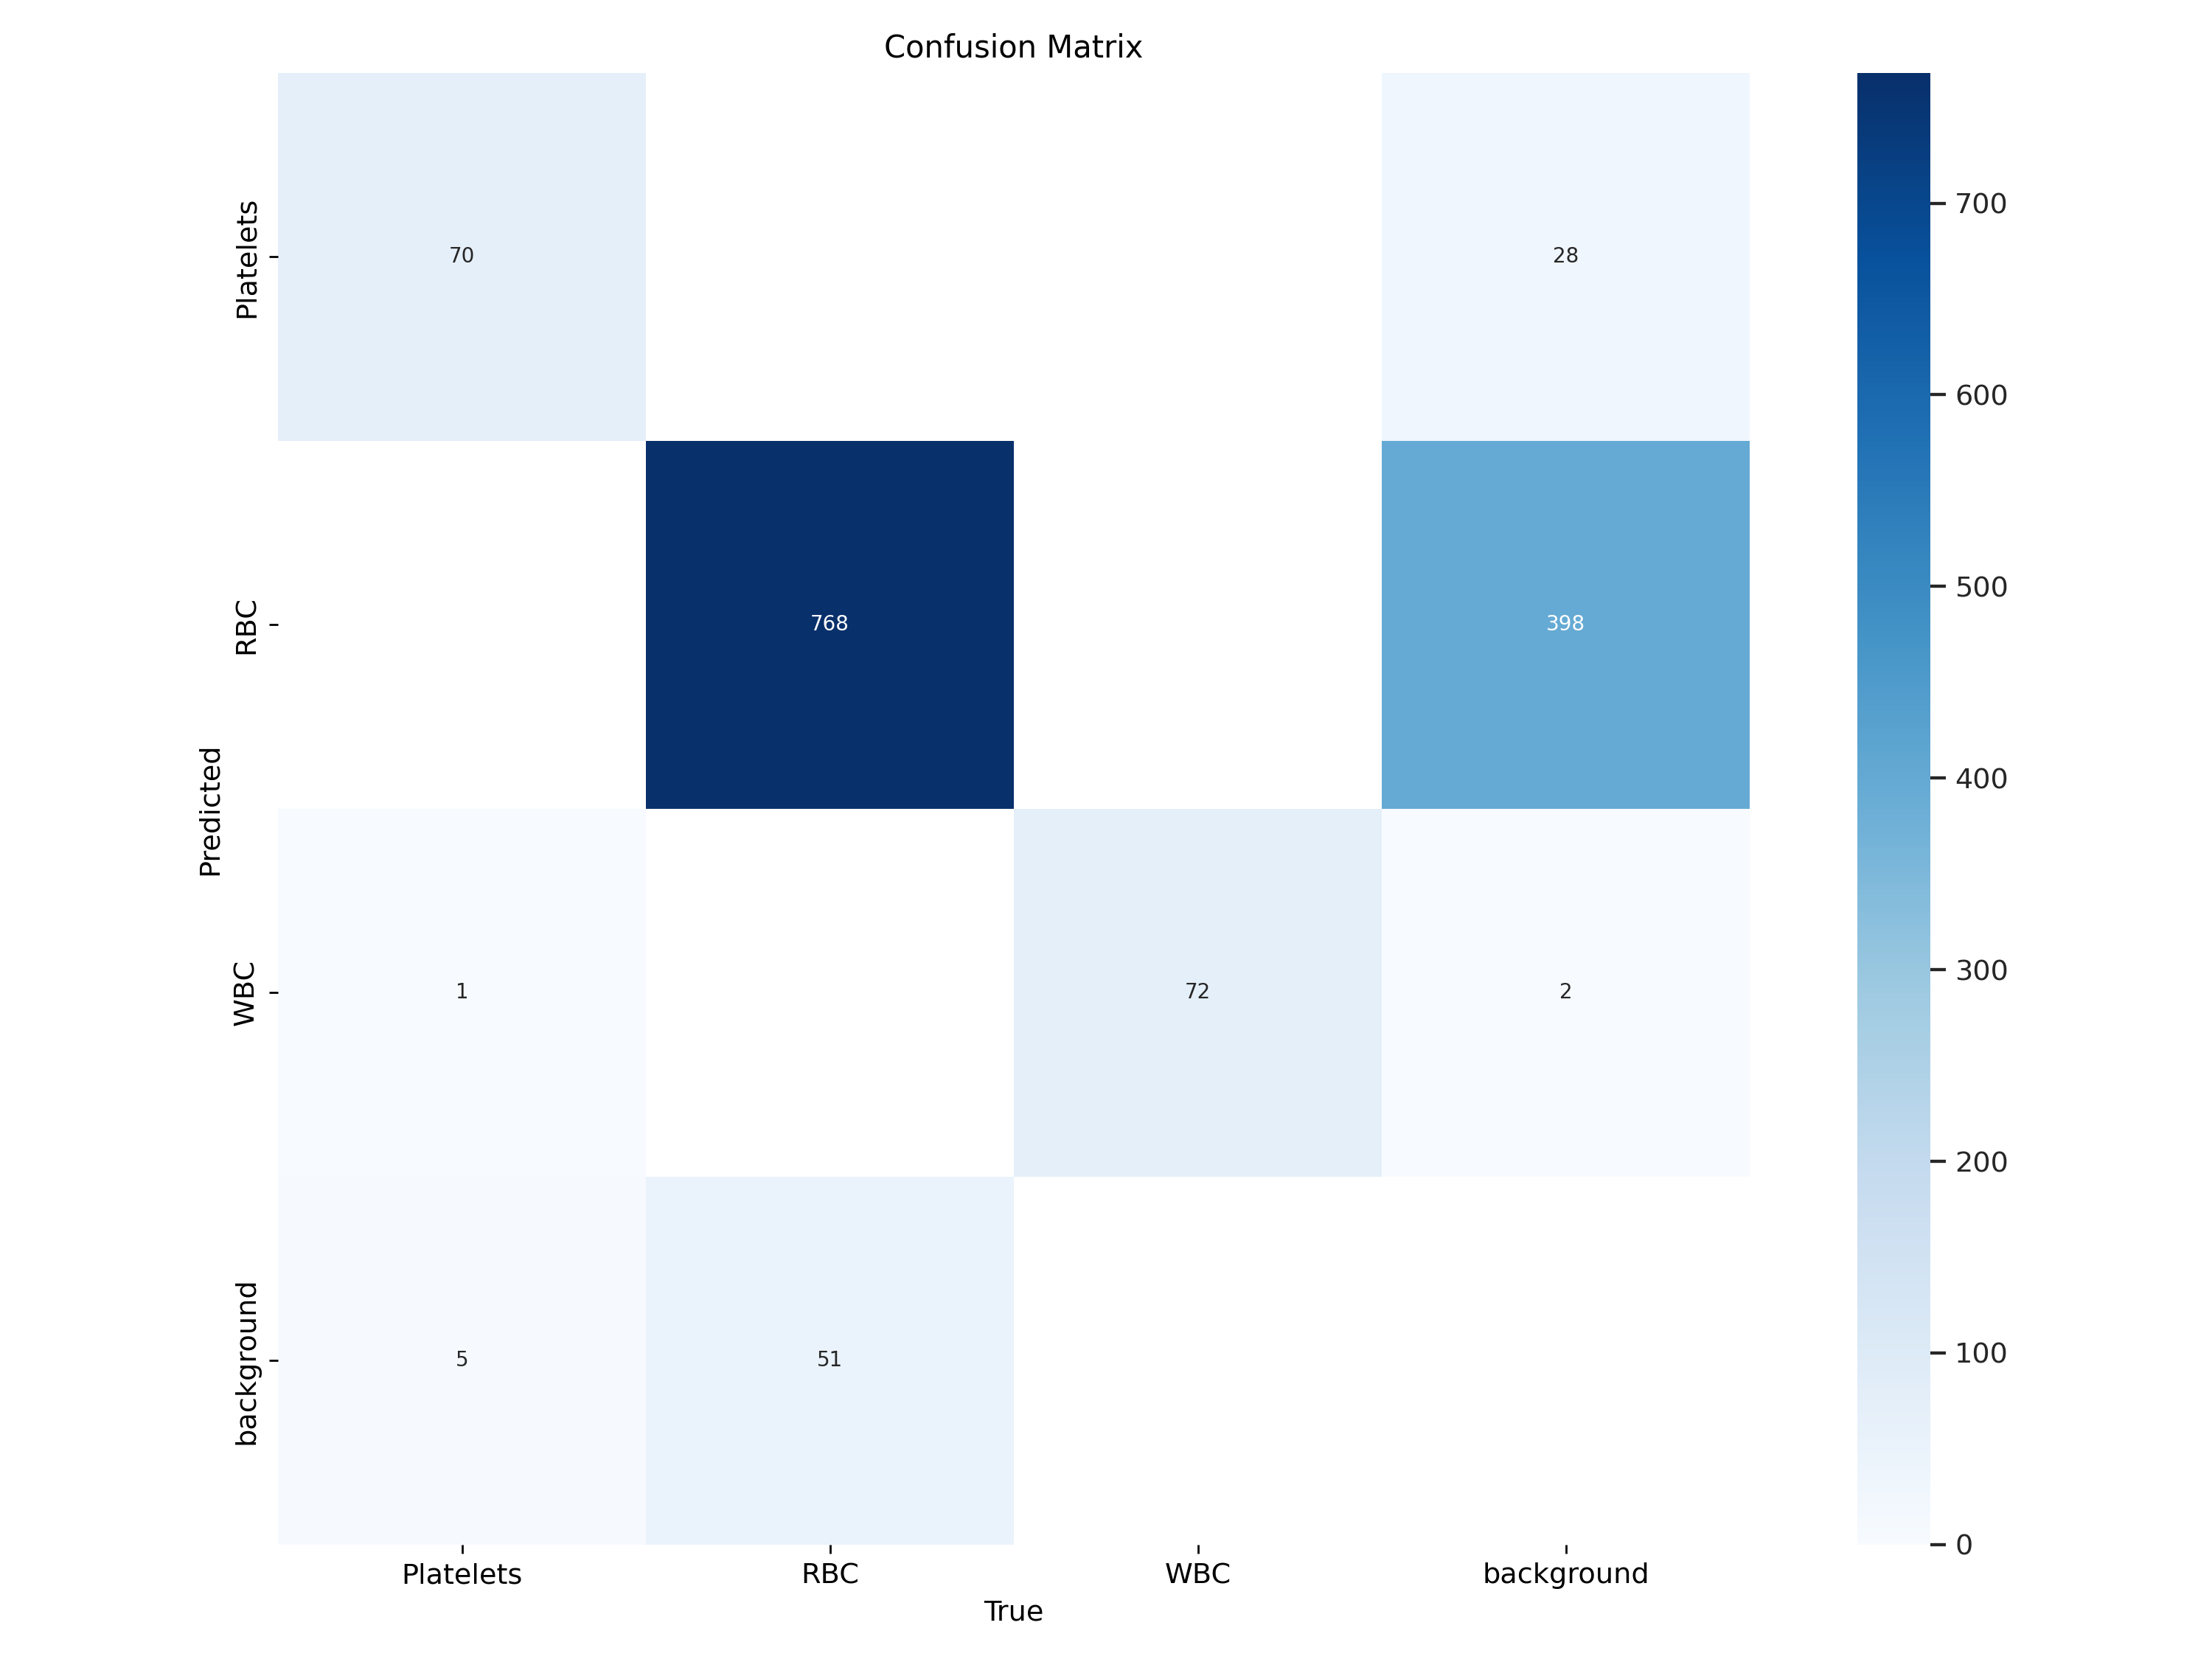

In [ ]:
Image(filename='/content/runs/detect/train/confusion_matrix.png', height=400)

In [ ]:
conf_mat = metrics.confusion_matrix.matrix

# Calculate IoU
iou = np.diag(conf_mat) / (conf_mat.sum(axis=1) + conf_mat.sum(axis=0) - np.diag(conf_mat))

# Calculate Dice coefficient
dice_coefficient = (2 * np.diag(conf_mat)) / (conf_mat.sum(axis=0) + conf_mat.sum(axis=1))

print(f'Test IoU: {np.mean(iou):.4f}')
print(f'Test Dice Coefficient: {np.mean(dice_coefficient):.4f}')

Test IoU: 0.5676
Test Dice Coefficient: 0.6406


In [ ]:
print(metrics.box.map75)

0.7696691939325793


In [ ]:
print(metrics.box.f1)

[    0.82803     0.81732       0.983]


In [ ]:
test_results = model('/content/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg')  # predict on an image


image 1/1 /content/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg: 640x640 1 Platelets, 27 RBCs, 1 WBC, 7.5ms
Speed: 3.6ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


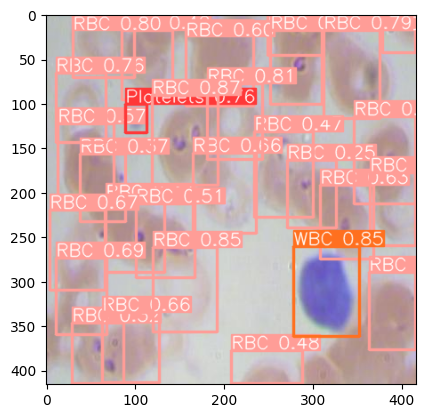

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

for r in test_results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im) # show image

GROUND TRUTH TRAINING DATA:


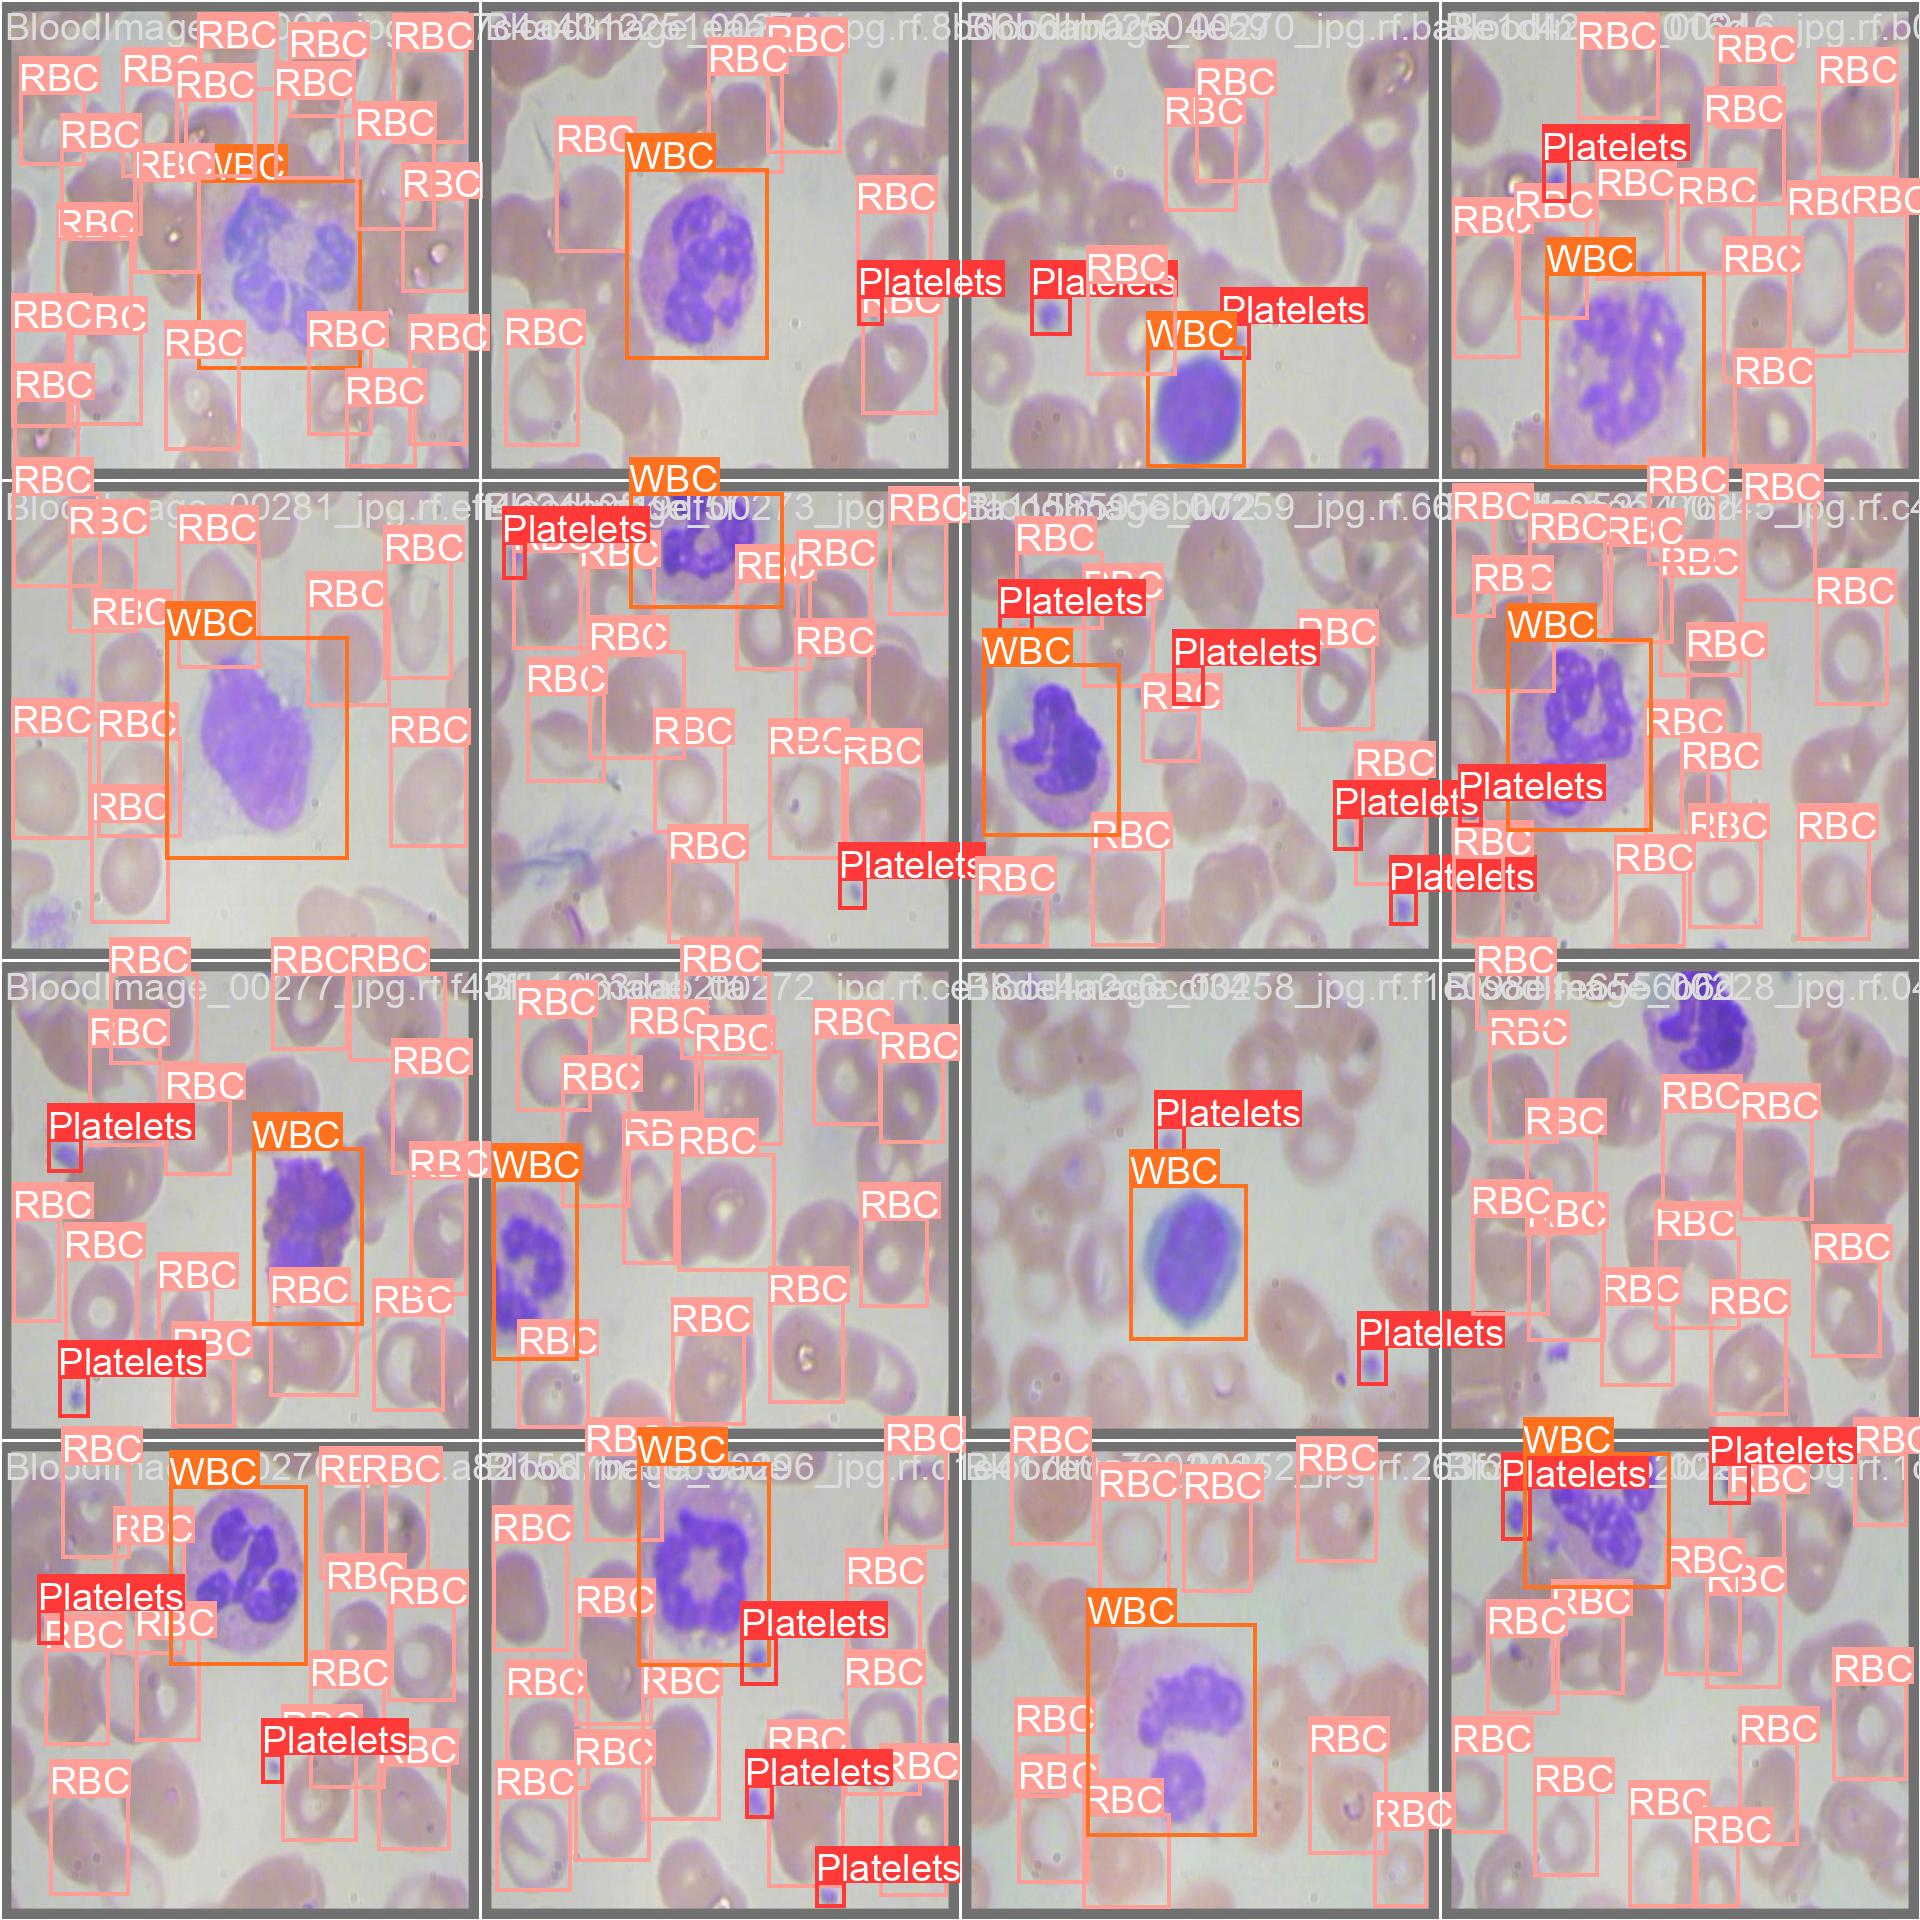

In [ ]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/runs/detect/train/val_batch0_labels.jpg', width=900)

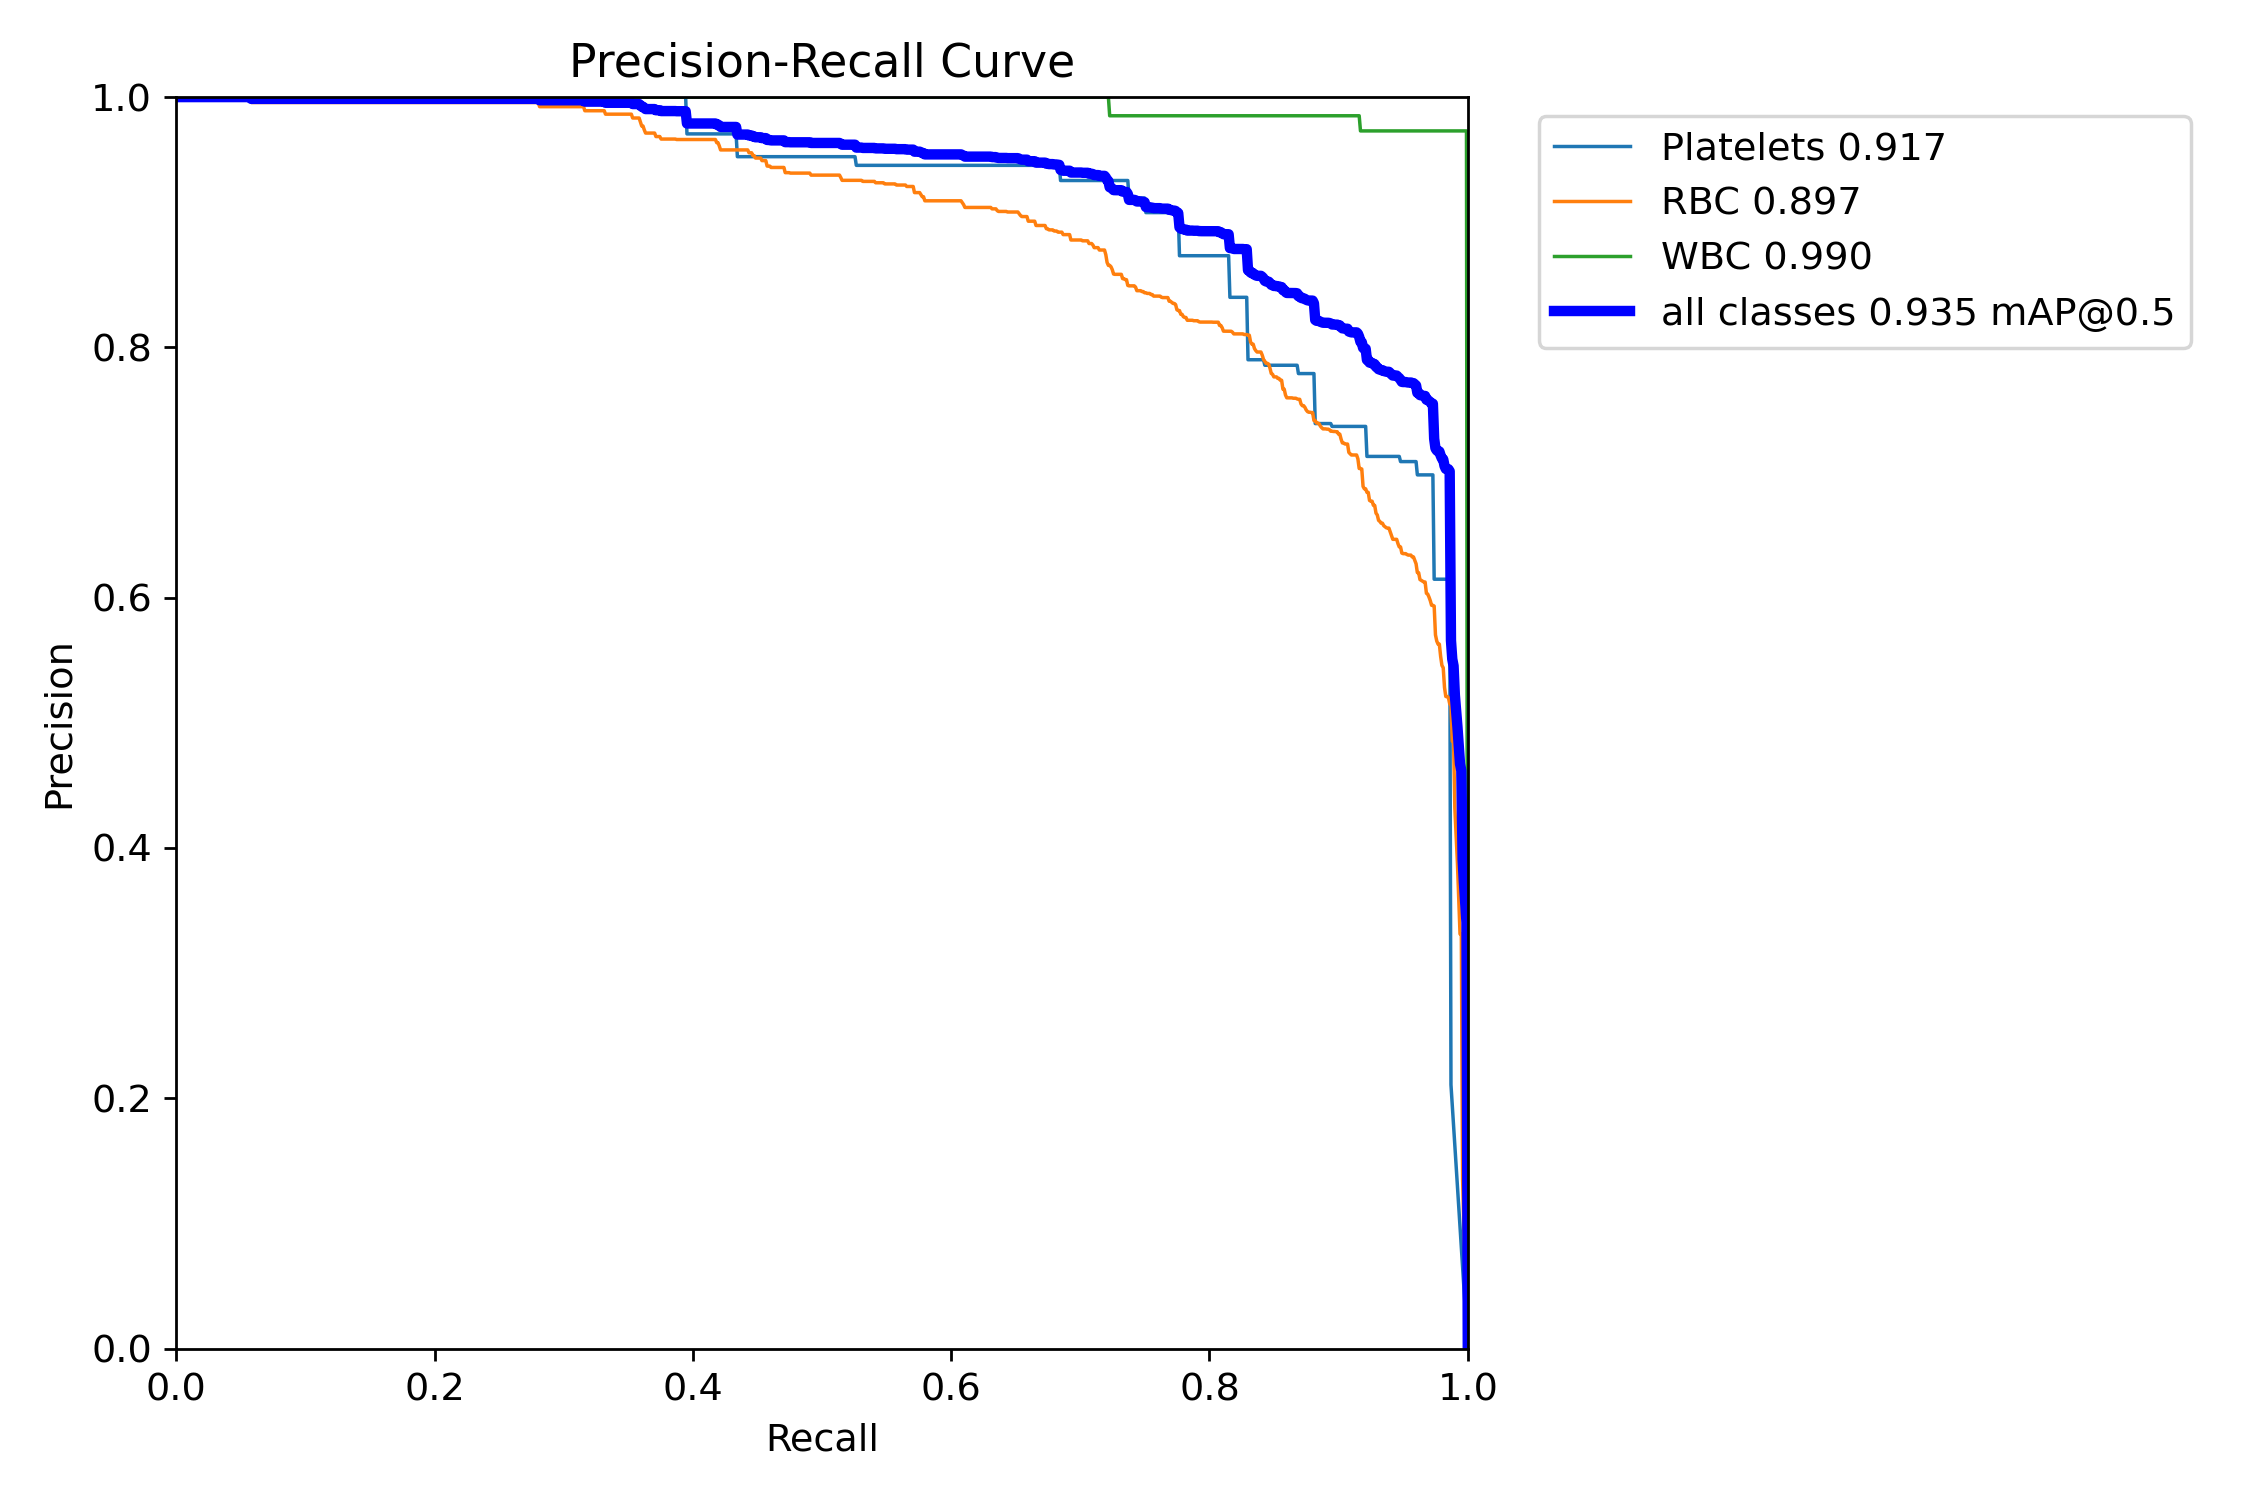

In [ ]:
Image(filename='/content/runs/detect/train/PR_curve.png', height=400)

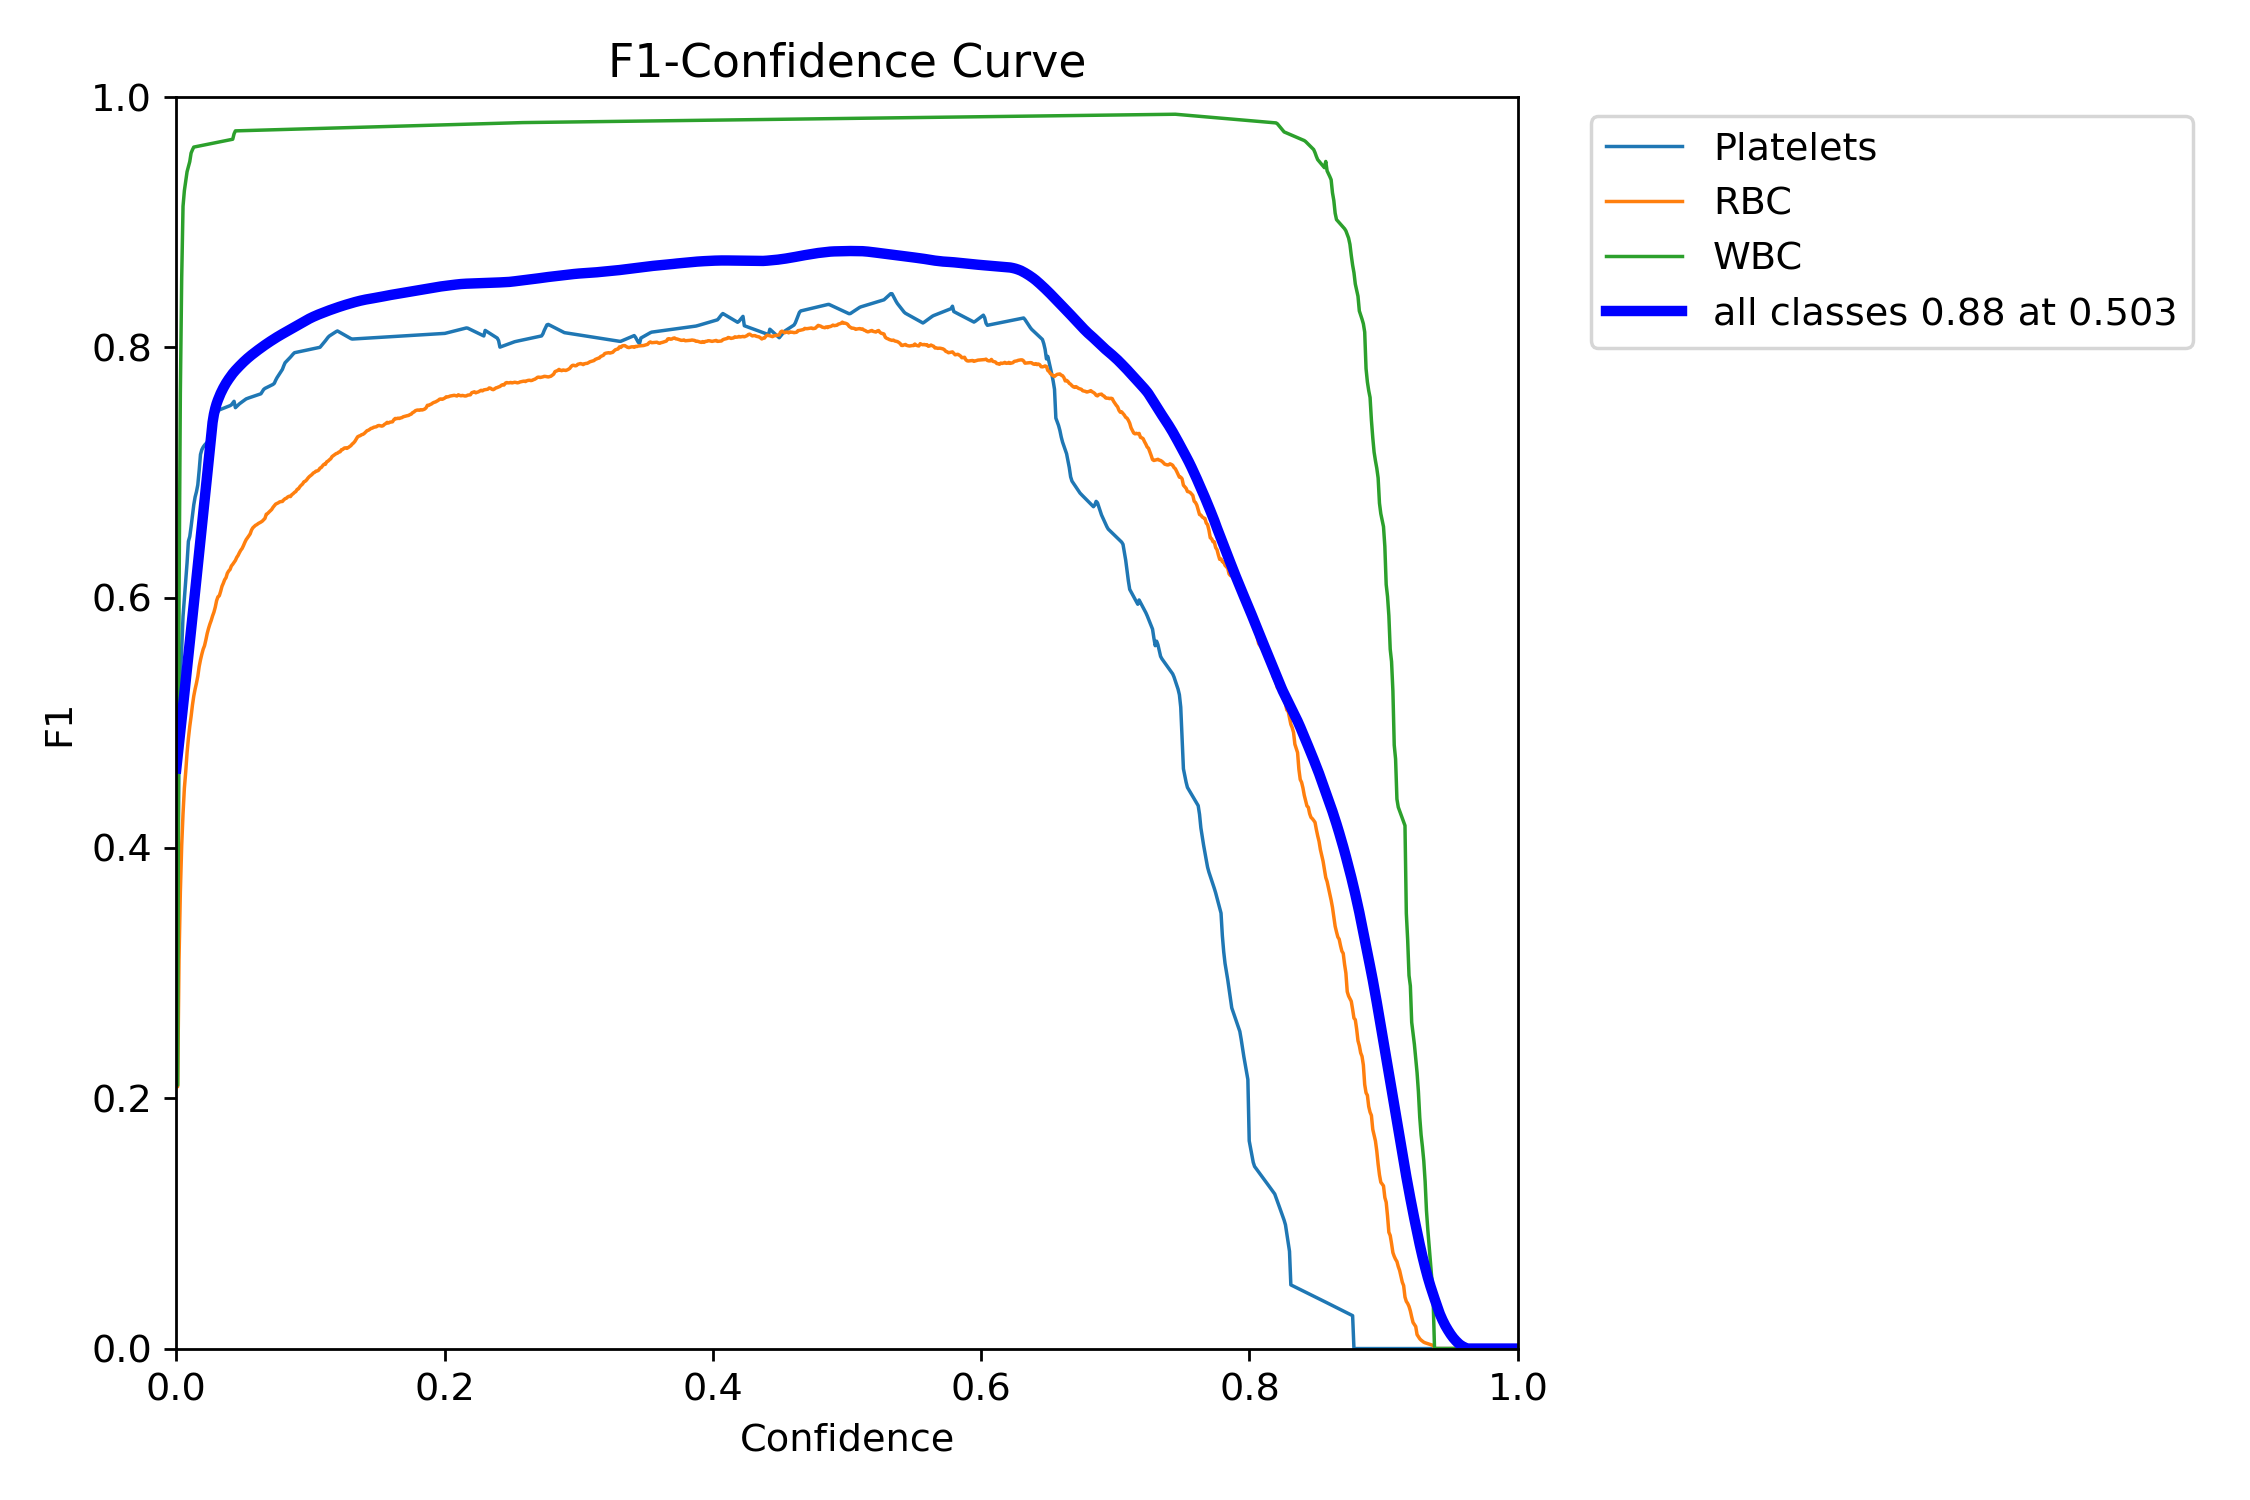

In [ ]:
Image(filename='/content/runs/detect/train/F1_curve.png', height=400)

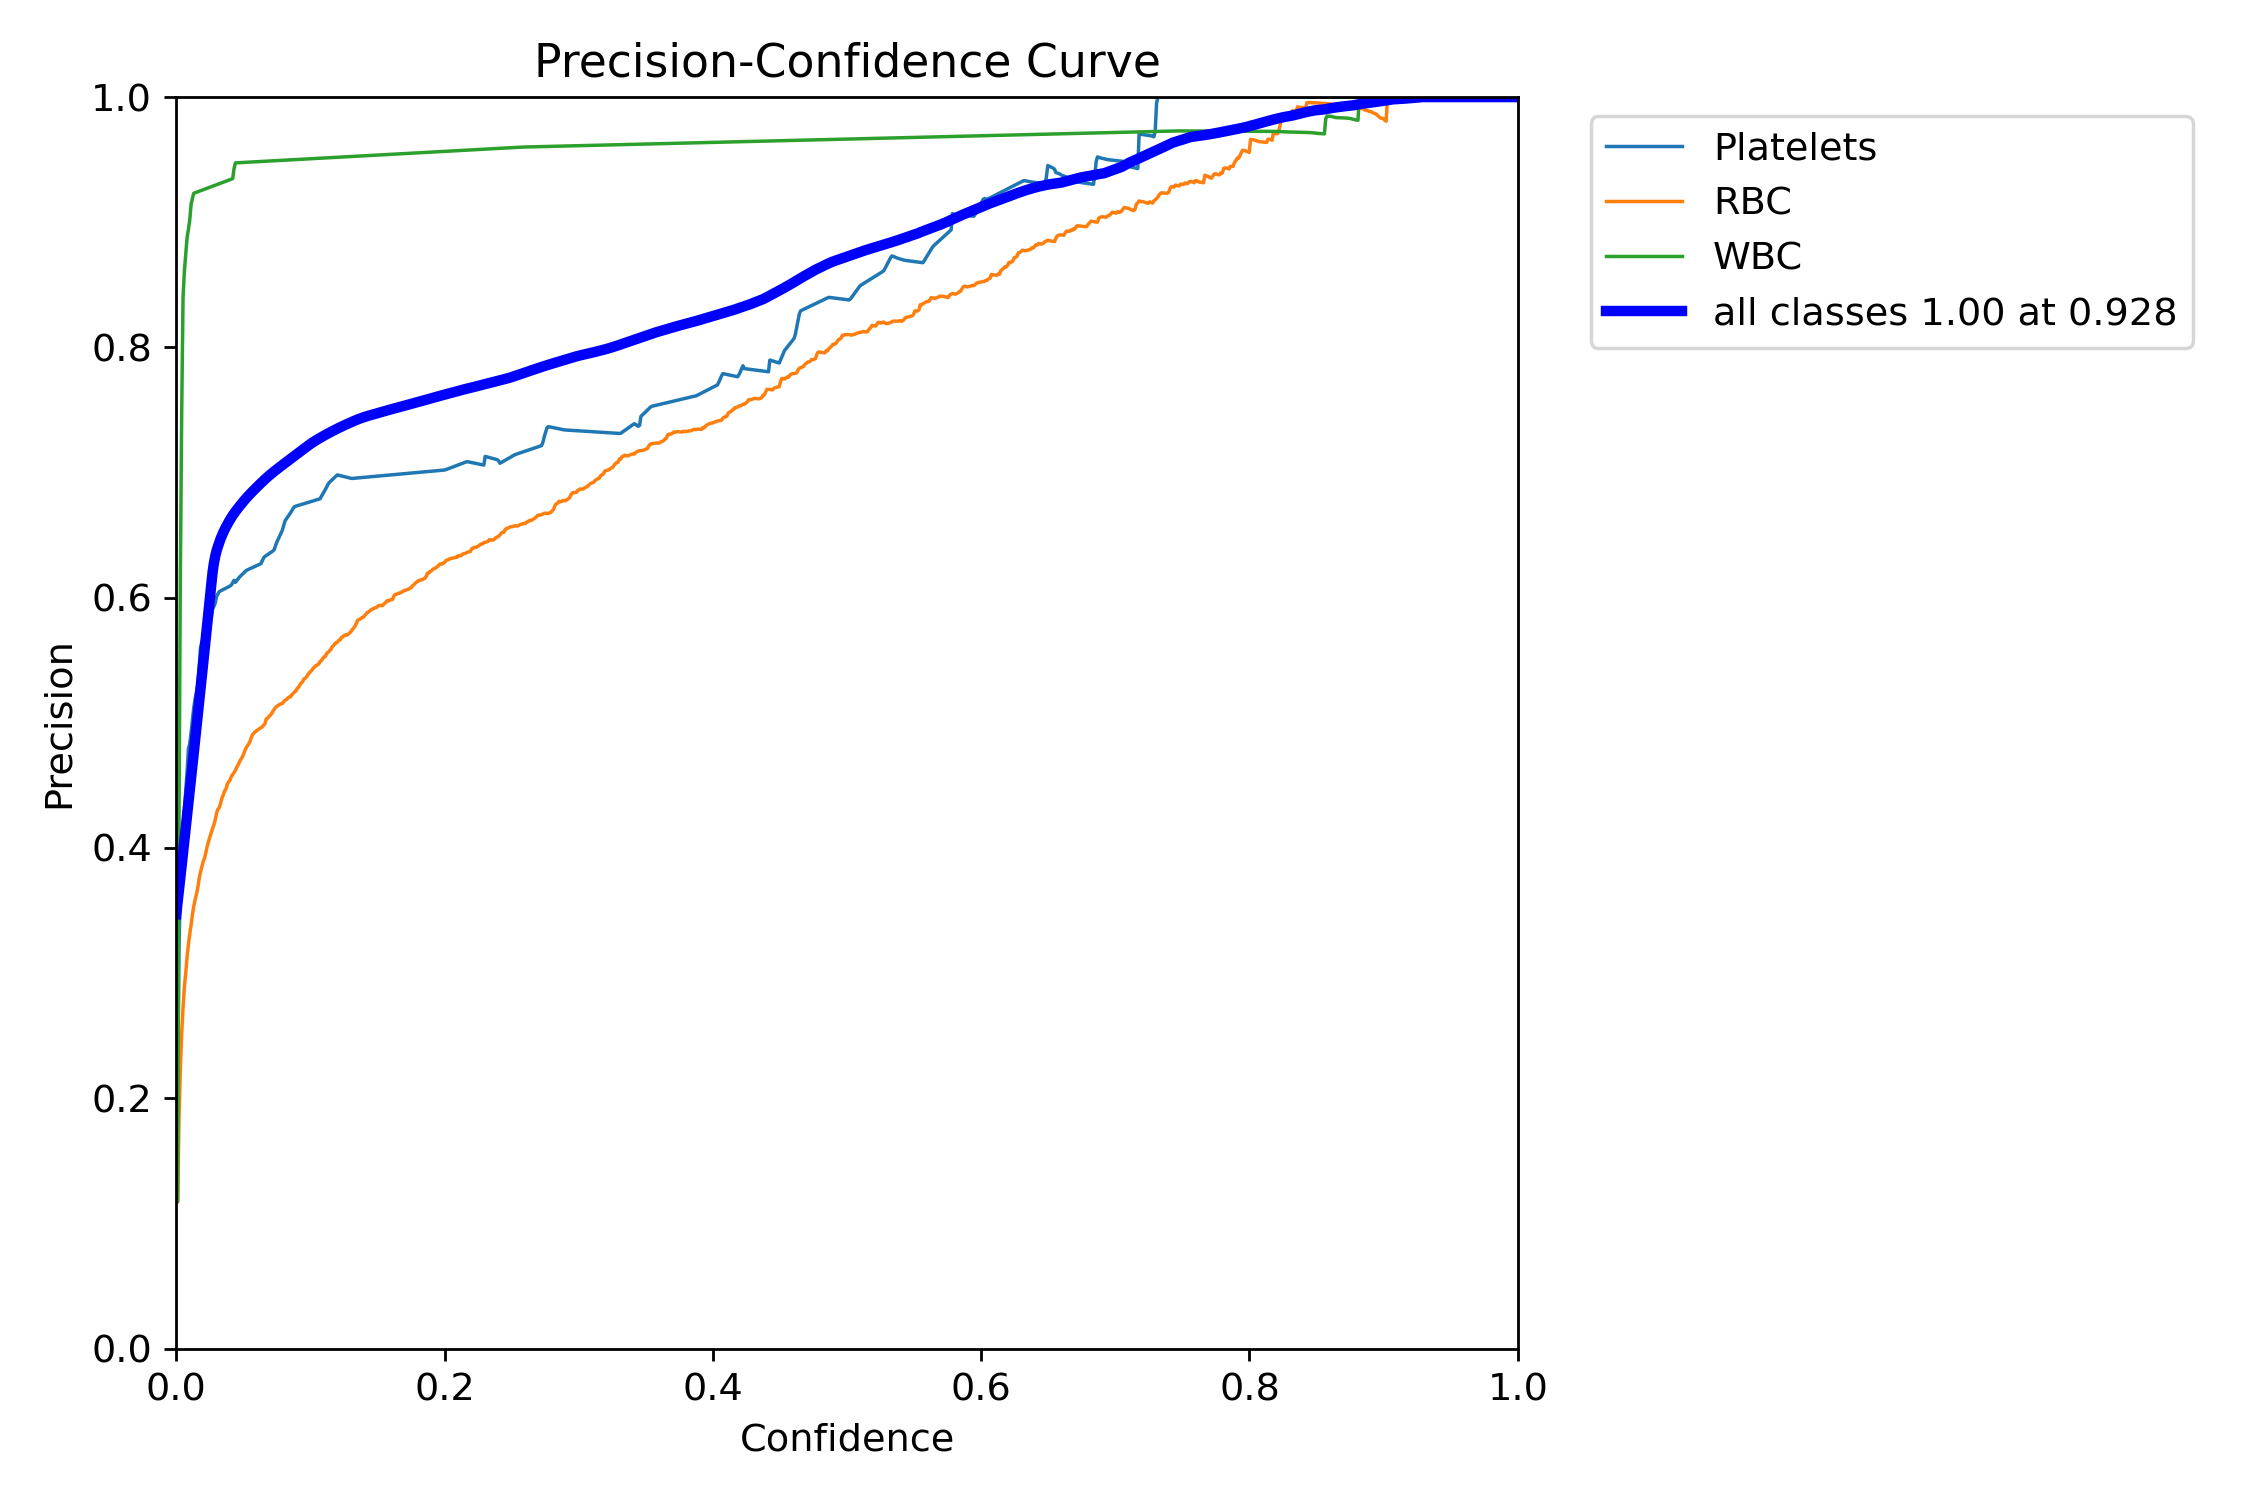

In [ ]:
Image(filename='/content/runs/detect/train/P_curve.png', height=400)

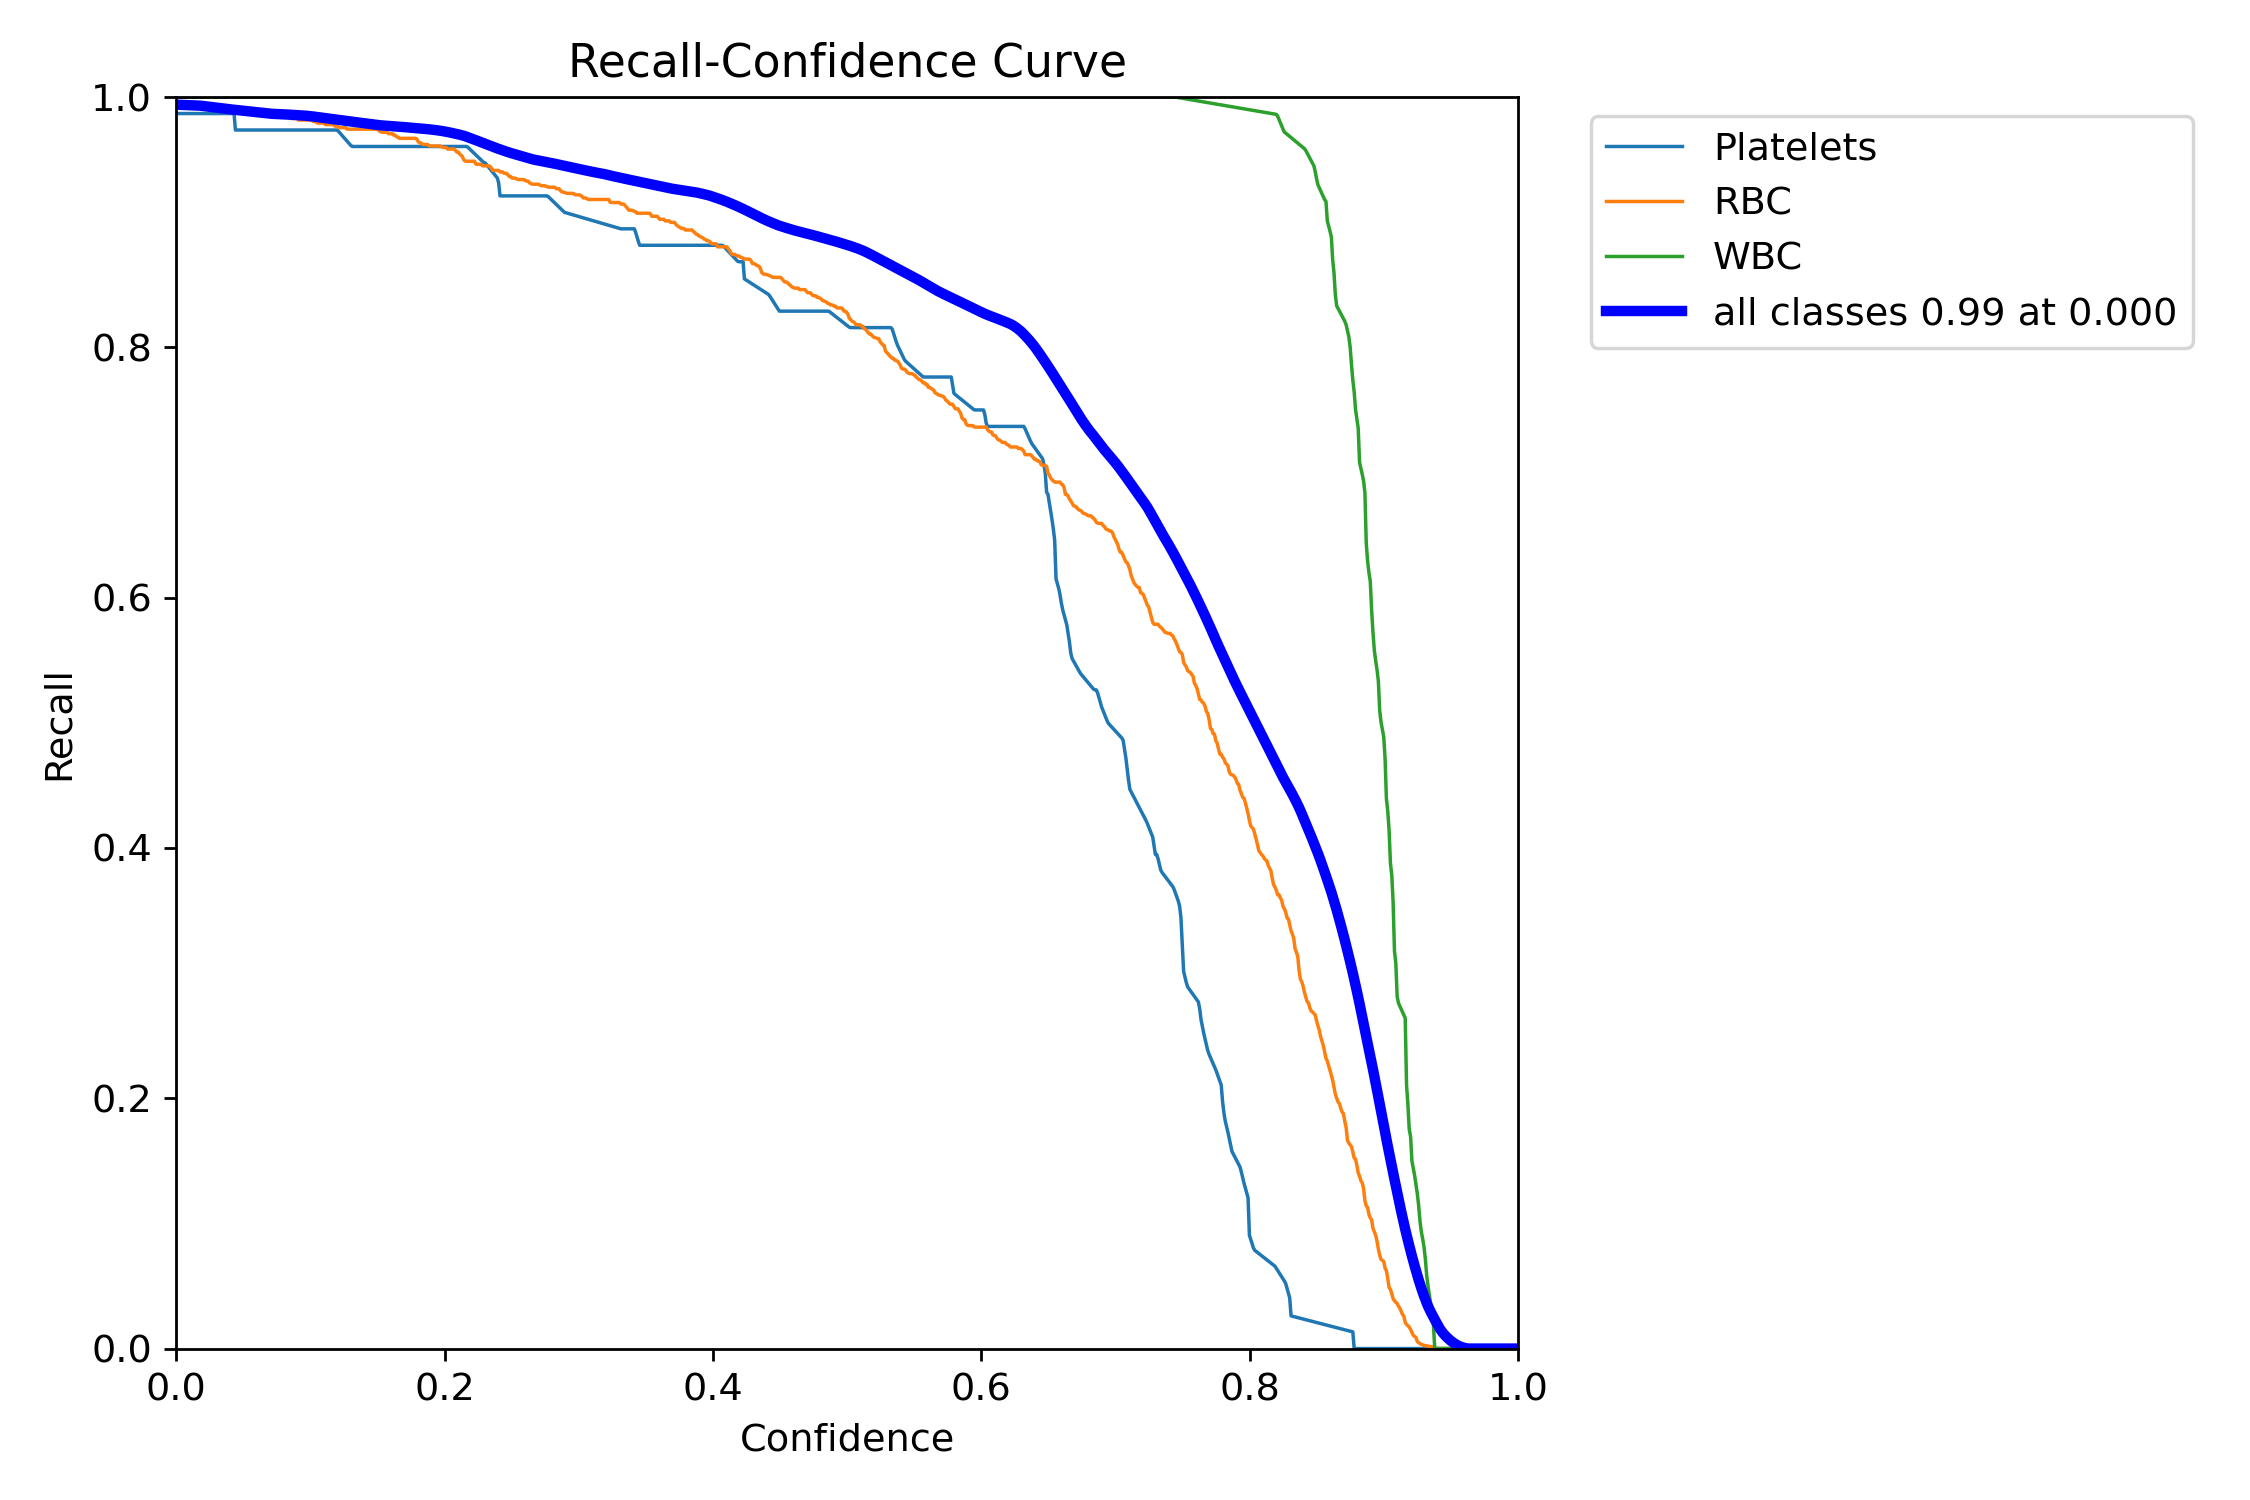

In [ ]:
Image(filename='/content/runs/detect/train/R_curve.png', height=400)

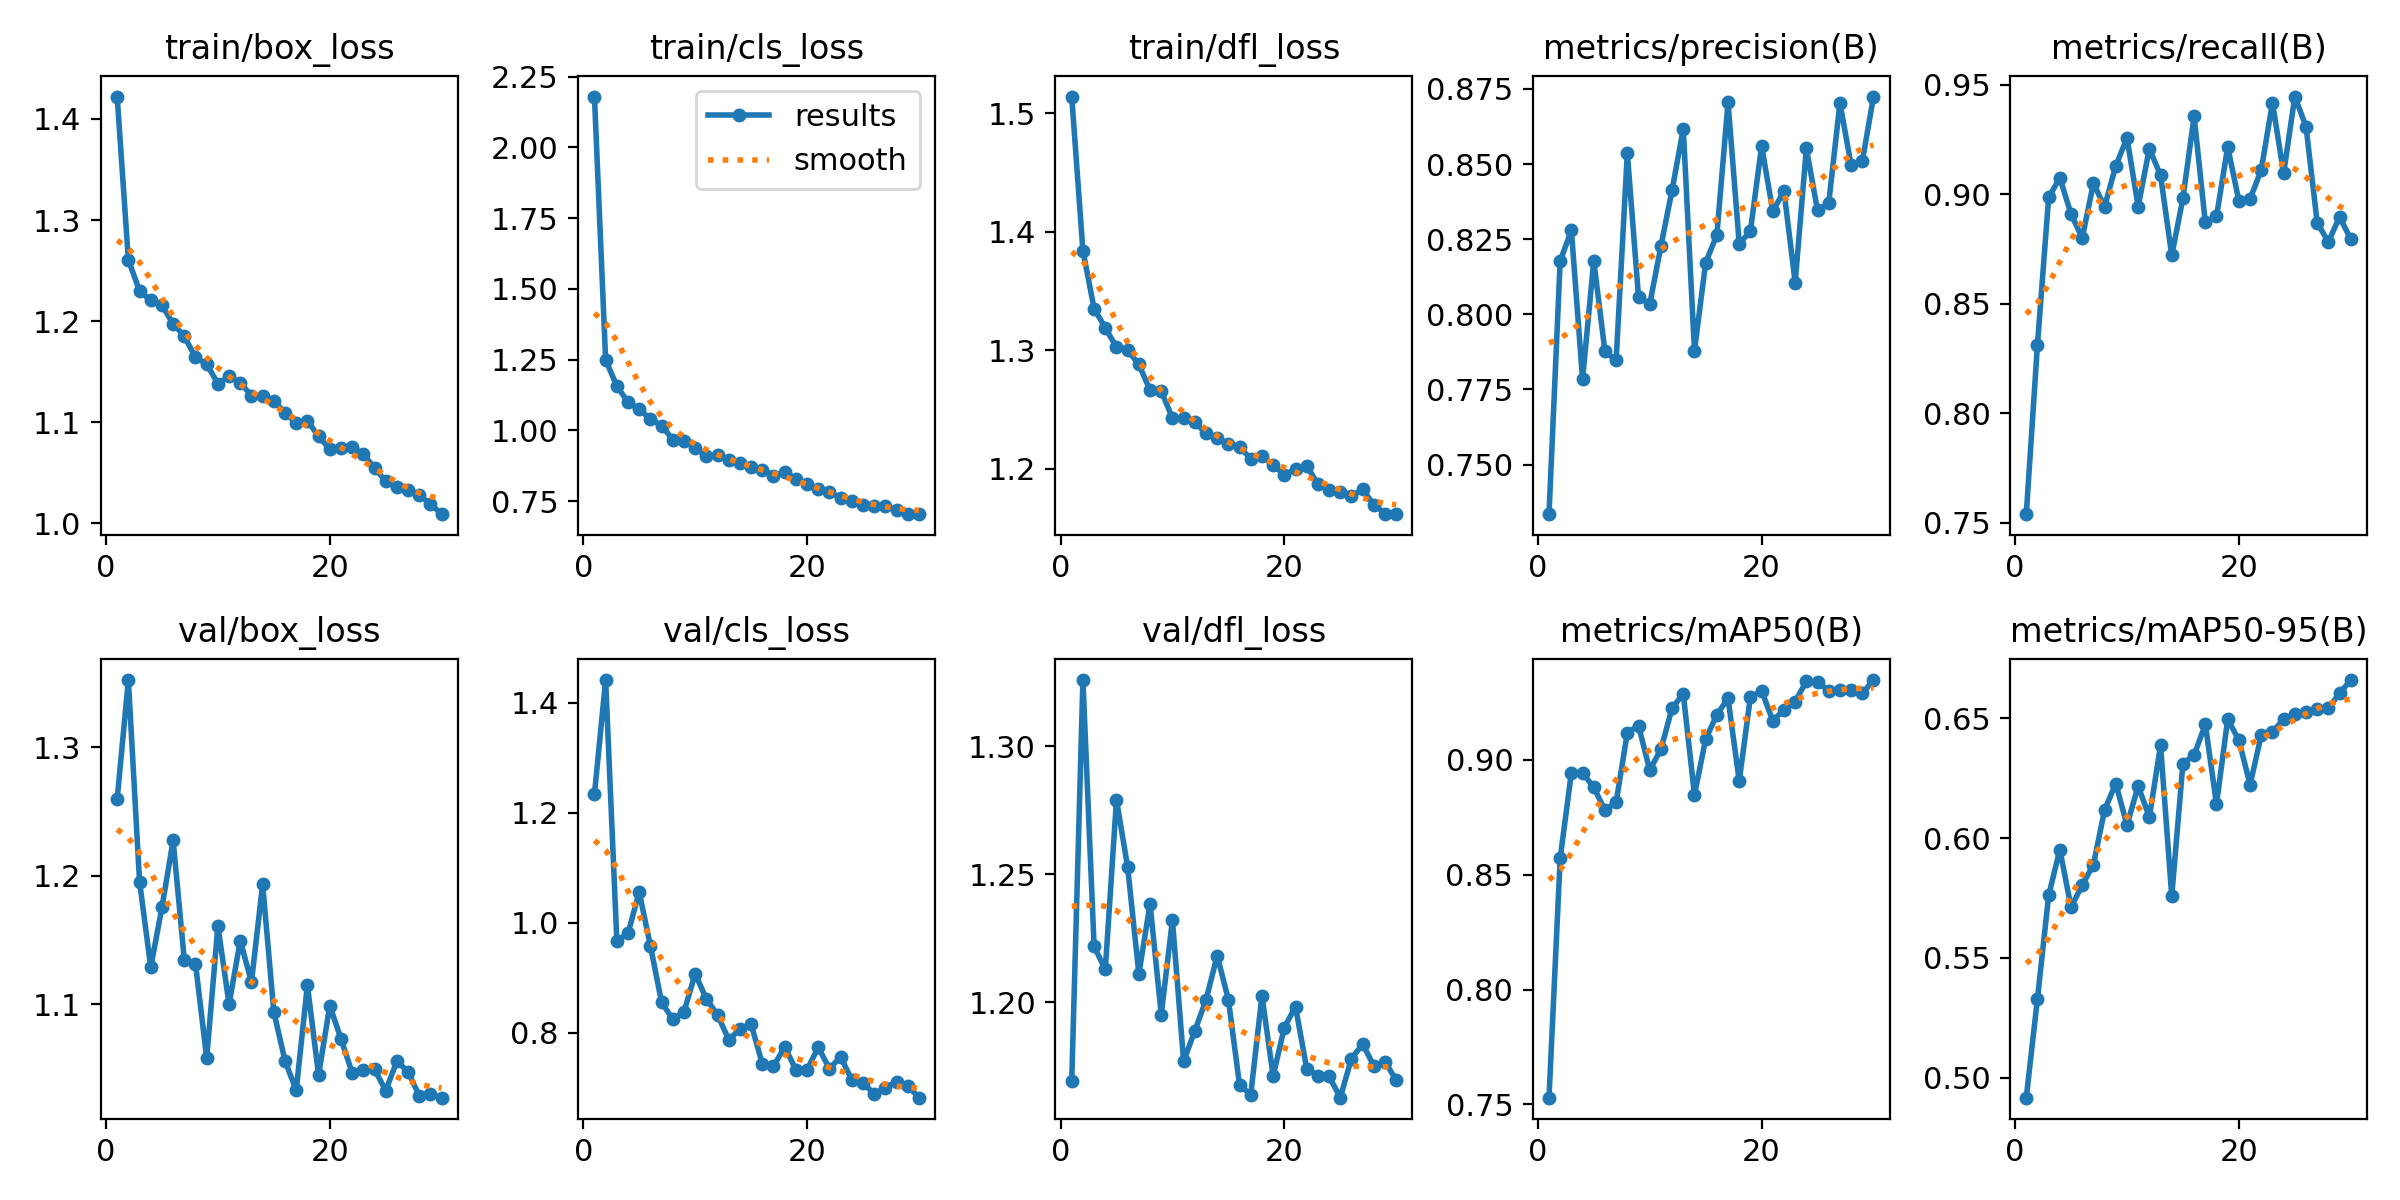

In [ ]:
Image(filename='/content/runs/detect/train/results.png', height=500)

In [ ]:
# # load a pretrained model (recommended for training)
# model = YOLO('yolov8n.pt')

# # Use the model
# results = model.train(data='data.yaml', epochs=40)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=40, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:00<00:00, 1507.20it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 648.42it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.92G      1.447      2.349      1.533        242        640: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         73        967      0.801      0.563      0.567      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      2.71G      1.267      1.306       1.38        261        640: 100%|██████████| 48/48 [00:18<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         73        967      0.705        0.8      0.856      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.53G      1.226      1.162      1.336        222        640: 100%|██████████| 48/48 [00:19<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         73        967      0.766      0.697      0.887      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.49G      1.198      1.093      1.305        227        640: 100%|██████████| 48/48 [00:20<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         73        967      0.723      0.917      0.906        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.67G      1.206      1.075      1.301        337        640: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


                   all         73        967      0.781       0.87      0.892      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       2.7G      1.183      1.013      1.276        259        640: 100%|██████████| 48/48 [00:19<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         73        967      0.789      0.841      0.877      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.67G      1.184      1.013      1.274        265        640: 100%|██████████| 48/48 [00:19<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         73        967      0.828      0.918      0.895      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.47G      1.154     0.9608      1.247        295        640: 100%|██████████| 48/48 [00:19<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         73        967      0.831      0.921      0.902      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       2.6G      1.143     0.9342      1.243        347        640: 100%|██████████| 48/48 [00:19<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]

                   all         73        967      0.802       0.91      0.901      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.62G      1.141     0.9267      1.234        230        640: 100%|██████████| 48/48 [00:21<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         73        967       0.85      0.924      0.917      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40       2.7G      1.116     0.8909      1.217        278        640: 100%|██████████| 48/48 [00:19<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


                   all         73        967      0.846      0.867      0.902      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.62G      1.122     0.8912      1.221        240        640: 100%|██████████| 48/48 [00:21<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         73        967      0.825      0.923      0.921      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.67G      1.131      0.894      1.222        225        640: 100%|██████████| 48/48 [00:21<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         73        967      0.823      0.907      0.903      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.77G      1.103     0.8581      1.201        255        640: 100%|██████████| 48/48 [00:19<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         73        967      0.845      0.882      0.916      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.73G      1.102     0.8586      1.204        212        640: 100%|██████████| 48/48 [00:19<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         73        967       0.85      0.848      0.894      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.69G      1.098     0.8498      1.196        330        640: 100%|██████████| 48/48 [00:20<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         73        967      0.846      0.904       0.92      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.62G      1.085     0.8347      1.186        271        640: 100%|██████████| 48/48 [00:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


                   all         73        967      0.846      0.879      0.907        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       2.5G      1.087     0.8275      1.191        281        640: 100%|██████████| 48/48 [00:19<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         73        967      0.832      0.925      0.927       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.62G      1.091     0.8202      1.185        315        640: 100%|██████████| 48/48 [00:19<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         73        967      0.811      0.923      0.898      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.62G      1.072     0.8071      1.176        221        640: 100%|██████████| 48/48 [00:19<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         73        967      0.814      0.903      0.903      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      2.67G       1.08     0.7925      1.182        266        640: 100%|██████████| 48/48 [00:21<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         73        967       0.83      0.867      0.894        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.49G      1.084     0.8011      1.187        291        640: 100%|██████████| 48/48 [00:19<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         73        967       0.82      0.895      0.912      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.65G      1.072     0.7767       1.18        204        640: 100%|██████████| 48/48 [00:19<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         73        967      0.816      0.897      0.911      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.67G      1.046     0.7713      1.166        251        640: 100%|██████████| 48/48 [00:21<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


                   all         73        967      0.847      0.887       0.92      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      2.66G      1.043      0.765      1.164        169        640: 100%|██████████| 48/48 [00:19<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         73        967      0.818      0.934       0.92      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      2.46G      1.051     0.7707      1.166        271        640: 100%|██████████| 48/48 [00:19<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         73        967      0.871      0.887      0.929      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.62G      1.044     0.7563      1.166        253        640: 100%|██████████| 48/48 [00:20<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         73        967      0.813      0.929      0.918      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      2.57G      1.042     0.7569      1.164        217        640: 100%|██████████| 48/48 [00:18<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         73        967      0.838       0.91      0.918      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.55G      1.055     0.7543      1.166        355        640: 100%|██████████| 48/48 [00:18<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]

                   all         73        967      0.841      0.886      0.917      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      2.47G      1.041     0.7435      1.158        240        640: 100%|██████████| 48/48 [00:21<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         73        967      0.819      0.931      0.929      0.653


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.87G       1.03      0.728      1.155        195        640: 100%|██████████| 48/48 [00:20<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         73        967      0.823       0.94      0.925       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      2.48G      1.018     0.7022      1.146        165        640: 100%|██████████| 48/48 [00:16<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]

                   all         73        967      0.856      0.912      0.926      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.46G      1.013     0.6908      1.143        163        640: 100%|██████████| 48/48 [00:16<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         73        967      0.883      0.868      0.927      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.48G     0.9912     0.6742      1.136        123        640: 100%|██████████| 48/48 [00:16<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         73        967      0.852      0.898      0.928      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      2.49G     0.9933     0.6639      1.139        155        640: 100%|██████████| 48/48 [00:16<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         73        967      0.881      0.873      0.918      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.47G     0.9921     0.6854      1.143        178        640: 100%|██████████| 48/48 [00:16<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         73        967       0.83      0.911      0.914      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.47G     0.9787     0.6504      1.123        169        640: 100%|██████████| 48/48 [00:16<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


                   all         73        967      0.868      0.884       0.92      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.47G     0.9741     0.6529       1.13        161        640: 100%|██████████| 48/48 [00:16<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         73        967      0.846      0.894       0.92       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.49G      0.973     0.6467      1.125        172        640: 100%|██████████| 48/48 [00:16<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         73        967      0.865      0.886      0.922      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      2.47G     0.9636     0.6406      1.119        188        640: 100%|██████████| 48/48 [00:16<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         73        967      0.853      0.879      0.922      0.651



40 epochs completed in 0.241 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


                   all         73        967      0.883      0.867      0.927      0.654
             Platelets         73         76      0.897      0.803      0.918      0.512
                   RBC         73        819      0.785      0.799      0.882      0.638
                   WBC         73         72      0.968          1      0.981      0.812
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# evaluate model performance on the validation set
# val_results = model.val()

Ultralytics YOLOv8.0.217 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


                   all         73        967      0.753       0.92      0.906      0.599
             Platelets         73         76      0.856      0.781      0.885       0.45
                   RBC         73        819      0.496      0.979      0.846      0.542
                   WBC         73         72      0.907          1      0.986      0.804
Speed: 0.5ms preprocess, 16.8ms inference, 0.0ms loss, 11.7ms postprocess per image
Results saved to runs/detect/train2
